## Previsione Ritorni BTC 5min ranks

In [1002]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras import metrics
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, concatenate
import keras.backend as K
from keras.utils import plot_model
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , mean_squared_error , mean_absolute_error , classification_report, log_loss, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras import regularizers
from xgboost import XGBClassifier
import scipy.stats as stats
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback, EarlyStopping
import seaborn as sns
import time
from scipy.optimize import minimize
import yfinance as yf
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1003]:
train_start = '2010-01-01'
train_end   = '2023-12-31'
stock_symb  = 'NVDA'

gap = 0.05

In [1004]:
my_factors = 'NG=F, CL=F, GC=F, GOVT, ^VIX, ^GDAXI, ^HSI, ^N225, EURUSD=X, USDJPY=X, BTC-USD, ETH-USD, ACWI'

my_factors = yf.download(my_factors,start=train_start, end=train_end)['Adj Close']
my_factors = np.log1p(my_factors.pct_change())
my_factors

[*********************100%***********************]  13 of 13 completed


/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


,ACWI,BTC-USD,CL=F,ETH-USD,EURUSD=X,GC=F,GOVT,NG=F,USDJPY=X,^GDAXI,^HSI,^N225,^VIX
Date,,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01,0.000000,NaN,0.000000,NaN,0.004379,0.000000,NaN,0.000000,0.000108,NaN,NaN,NaN,0.000000
2010-01-04,0.020363,NaN,0.026731,NaN,0.002363,0.020336,NaN,0.054483,-0.004584,NaN,NaN,NaN,-0.078660
2010-01-05,0.008306,NaN,0.003185,NaN,-0.004031,0.000358,NaN,-0.042885,-0.009887,-0.002722,0.020693,0.002535,-0.035038
2010-01-06,-0.000230,NaN,0.017097,NaN,0.002647,0.015795,NaN,0.063906,0.008383,0.000409,0.006134,0.004635,-0.009868
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,0.005849,-0.004541,0.026661,-0.008562,-0.001380,0.000100,0.005133,0.023086,0.002522,0.007687,0.002733,0.013915,-0.076233
2023-04-29,0.000000,-0.003133,0.000000,0.008631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-04-30,0.000000,0.000694,0.000000,-0.016902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### STOCK

In [1005]:
stock = yf.download(stock_symb,start=train_start, end=train_end)
stock['Gap'] = 1*(stock['Open'].shift(-1) / stock['Close'] -1)
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Gap
Date,,,,,,,
2009-12-31,4.677500,4.737500,4.665000,4.670000,4.285174,70034000,-0.009101
2010-01-04,4.627500,4.655000,4.527500,4.622500,4.241590,80020400,-0.003786
2010-01-05,4.605000,4.740000,4.605000,4.690000,4.303525,72864800,-0.000533
2010-01-06,4.687500,4.730000,4.642500,4.720000,4.331055,64916800,-0.005297
2010-01-07,4.695000,4.715000,4.592500,4.627500,4.246178,54779200,-0.008104
...,...,...,...,...,...,...,...
2023-04-25,270.779999,272.470001,262.250000,262.410004,262.410004,37852700,0.029000
2023-04-26,270.019989,273.299988,267.049988,269.559998,269.559998,40633700,0.015099
2023-04-27,273.630005,274.950012,266.250000,272.260010,272.260010,37716100,-0.000037


In [1006]:
stock_filter = pd.DataFrame()

stock_filter['return'] = stock['Adj Close'].pct_change()
stock_filter['range'] = (np.log(stock["High"]/stock["Low"]))
stock_filter['open_close'] = (np.log(stock["Close"]/stock["Open"]))
stock_filter['vol_ratio'] = stock['Volume'] / stock['Volume'].rolling(22).mean()
stock_filter['vol_ptc'] = stock['Volume'].pct_change()

# stock_filter['mm_5'] = stock['Adj Close'] / stock['Adj Close'].rolling(5).mean()-1
stock_filter['mm_22'] = stock['Adj Close'] / stock['Adj Close'].rolling(22).mean()-1
stock_filter['mm_50'] = stock['Adj Close'] / stock['Adj Close'].rolling(50).mean()-1
stock_filter['mm_200'] = stock['Adj Close'] / stock['Adj Close'].rolling(200).mean()-1
stock_filter['std_22'] = stock['Adj Close'].pct_change().rolling(22).std(ddof=1)
# stock_filter['range_22'] = (np.log(stock["High"]/stock["Low"])).rolling(22).mean() 

stock_filter['log_ret_1'] = stock_filter['return'].shift(1)
stock_filter['log_ret_2'] = stock_filter['return'].shift(2)
stock_filter['log_ret_3'] = stock_filter['return'].shift(3)


# stock_filter['next_ret'] = stock_filter['return'].shift(-1).apply(lambda x: 1 if x > 0 else 0)
if gap > 0 :
    stock_filter['next_gap'] = stock['Gap'].apply(lambda x: 1 if x > gap else 0)
else:
    stock_filter['next_gap'] = stock['Gap'].apply(lambda x: 1 if x < gap else 0)

In [1007]:
df = pd.concat([my_factors,stock_filter], axis=1)
# df = btc.copy()
df.dropna(inplace=True)

In [1008]:
df.columns

Index(['ACWI', 'BTC-USD', 'CL=F', 'ETH-USD', 'EURUSD=X', 'GC=F', 'GOVT',
       'NG=F', 'USDJPY=X', '^GDAXI', '^HSI', '^N225', '^VIX', 'return',
       'range', 'open_close', 'vol_ratio', 'vol_ptc', 'mm_22', 'mm_50',
       'mm_200', 'std_22', 'log_ret_1', 'log_ret_2', 'log_ret_3', 'next_gap'],
      dtype='object')

In [1009]:
print(df['next_gap'].value_counts())
ratio = df['next_gap'].value_counts()[0] / df['next_gap'].value_counts()[1]
print(ratio)

0.0    1358
1.0      15
Name: next_gap, dtype: int64
90.53333333333333


In [1010]:
print('Percentuale di 1 sul totale: ',round(100* df['next_gap'].value_counts()[1]/len(df),2), '%')

Percentuale di 1 sul totale:  1.09 %


In [1011]:
def matrix(y_test, y_pred):
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm / cm.sum(axis=1)[: , np.newaxis]
    # Set the figure size
    plt.figure(figsize=(8, 6))
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm_norm, annot=True, cmap='coolwarm_r', fmt='.3f', 
                # xticklabels=['0', 'DROP!'], yticklabels=['NULL', 'DROP!']
                )
    # Set the axis labels and title
    plt.xlabel('Predicted sign')
    plt.ylabel('True sign')
    # plt.title('Logistic Confusion Matrix | ' +str(bips) +' bips')
    plt.show()
    return

---

## LogisticRegression

In [1012]:
# Split the data into X & y
X = df.drop('next_gap', axis = 1)
y = df['next_gap'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=333, shuffle=True)

In [1013]:
kf = KFold(n_splits=25, random_state=333, shuffle=True)
C_List = np.geomspace(1e-5, 1e6, num=500)
weights = {0:1, 1:ratio}
Log_regCV = LogisticRegressionCV(random_state=None, Cs = C_List, solver ='lbfgs', cv=kf, class_weight=weights, max_iter=2500, n_jobs=-1)
Log_regCV.fit(X_train, y_train)
print("The CA is:", Log_regCV.score(X_test, y_test))
pred_proba_t = Log_regCV.predict_proba(X_test)
log_lossCV = log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_lossCV)
print("The optimal C parameter is: ", Log_regCV.C_)

The CA is: 0.9710144927536232
The Logistic Loss is:  0.601279875203838
The optimal C parameter is:  [1.e-05]


In [1014]:
weights = {0:1, 1:ratio}
log_reg = LogisticRegression(random_state=333, solver = 'lbfgs', C=Log_regCV.C_[0], class_weight=weights, max_iter=2500, n_jobs=-1)
log_reg.fit(X_train, y_train)
score = log_reg.score(X_test, y_test)

pred_proba_t = log_reg.predict_proba(X_test)
log_loss2 = log_loss(y_test, pred_proba_t)

y_pred = log_reg.predict(X_test)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

Testing Acc: 0.9710144927536232
Log Loss: 0.6012798730019313


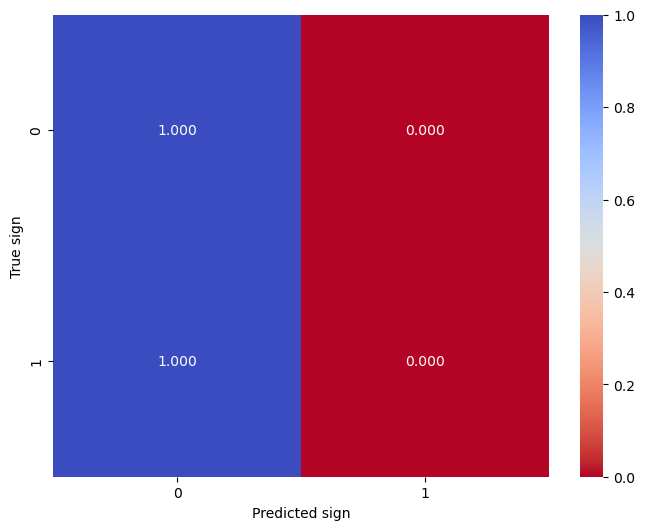

In [1015]:
# Create the confusion matrix
matrix(y_test, y_pred)

                       0
vol_ptc     4.458954e-04
vol_ratio   3.403685e-04
mm_200      2.150953e-04
log_ret_2   1.453321e-04
range       5.368454e-05
mm_50       4.932683e-05
^VIX        4.778608e-05
std_22      3.794932e-05
GC=F        1.685153e-05
GOVT        1.564595e-05
EURUSD=X    9.741986e-07
USDJPY=X   -1.051451e-05
^N225      -2.605311e-05
log_ret_1  -3.900953e-05
^HSI       -4.306029e-05
open_close -4.695974e-05
mm_22      -4.992067e-05
CL=F       -5.042860e-05
NG=F       -6.474811e-05
ACWI       -6.767978e-05
^GDAXI     -7.001193e-05
log_ret_3  -8.427363e-05
return     -1.041056e-04
BTC-USD    -1.808363e-04
ETH-USD    -1.921712e-04


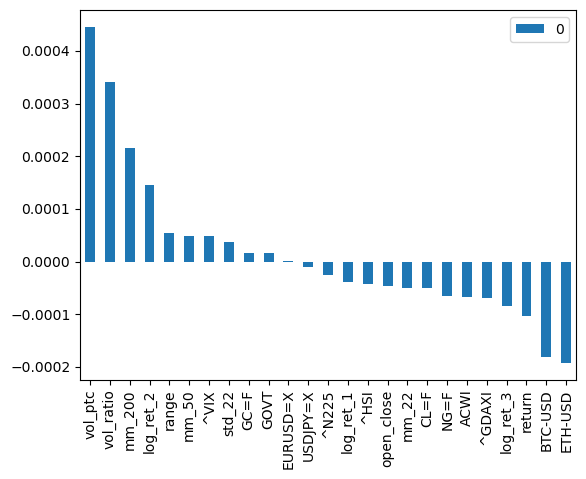

In [1016]:
beta_coeff = pd.DataFrame(log_reg.coef_[0], index=X.columns).sort_values(0, ascending=False)
important_features = list(beta_coeff.index)
beta_coeff.plot(kind='bar')
print(beta_coeff)

In [1017]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data.sort_values(by='VIF', ascending=False, inplace=True)
print(vif_data)

       feature        VIF
14       range  10.431696
16   vol_ratio   7.787018
21      std_22   7.676374
19       mm_50   6.619776
18       mm_22   6.046900
13      return   5.076689
0         ACWI   4.502745
15  open_close   3.440434
3      ETH-USD   3.049752
1      BTC-USD   3.013955
20      mm_200   2.682654
12        ^VIX   2.255665
9       ^GDAXI   2.135181
22   log_ret_1   1.623508
11       ^N225   1.601274
17     vol_ptc   1.430383
10        ^HSI   1.409233
8     USDJPY=X   1.337507
23   log_ret_2   1.337137
4     EURUSD=X   1.325637
24   log_ret_3   1.230343
6         GOVT   1.223282
5         GC=F   1.197250
2         CL=F   1.141403
7         NG=F   1.025865
